<a href="https://colab.research.google.com/github/divya-r-kamat/NLP-With-PyTorch/blob/master/TextSegmentation/TextSegmentation_using_textsplit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install textsplit

     |████████████████████████████████| 163kB 20.2MB/s 


In [3]:
import os
# import word2vec
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import gensim
import seaborn as sns
from textsplit.tools import SimpleSentenceTokenizer
sentence_tokenizer = SimpleSentenceTokenizer()

Read the wrangled segments csv file

In [4]:
segments = pd.read_csv("/content/drive/MyDrive/Omdena/MavinAI/outputs/data_annotated_segments.csv")
segments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2936 entries, 0 to 2935
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   text                               2936 non-null   object
 1   article_cluster                    2936 non-null   int64 
 2   id                                 2936 non-null   int64 
 3   segment_number                     2936 non-null   int64 
 4   segments_in_article                2936 non-null   int64 
 5   title                              2936 non-null   object
 6   Accountablity Score                2741 non-null   object
 7   Fact-basedness Score               2920 non-null   object
 8   Inaccuracy Score                   2730 non-null   object
 9   Influenctial Score                 2753 non-null   object
 10  Opinionated Score                  2748 non-null   object
 11  Unobjectivity Tone of Voice Score  2735 non-null   object
dtypes: int

Calculate the length of the text segment

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Text Length Distribution in segments')

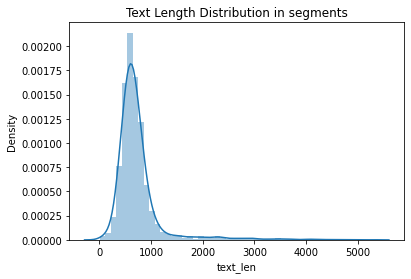

In [5]:
segments['text_len'] = segments['text'].astype(str).apply(len)
sns.distplot(segments['text_len']).set_title("Text Length Distribution in segments")


In [6]:
def sen_len(text):
  number_of_sentences = sentence_tokenizer(text)
  return(len(number_of_sentences))

In [7]:
segments['num_sen'] = segments['text'].astype(str).apply(sen_len)
segments[['num_sen']].describe()

,num_sen
count,2936.000000
mean,5.715940
std,4.051336
min,0.000000
25%,4.000000
50%,5.000000
75%,6.000000
max,58.000000


Maximum number of sentences in a segment is 58, mean is ~5.7 and median sentences in a segment is 5

In [8]:
segments[['text_len']].describe()

,text_len
count,2936.000000
mean,740.577657
std,486.323426
min,11.000000
25%,520.000000
50%,639.000000
75%,792.250000
max,5305.000000


Majority of the segments are of length ~792 , mean length is 740 and median length is 639. Note: this includes punctuation and stop words as well

In [9]:
%matplotlib inline
from textsplit.tools import get_penalty, get_segments
from textsplit.algorithm import split_optimal, split_greedy, get_total

Load Google News Vector

In [10]:
word2vec = gensim.models.KeyedVectors.load_word2vec_format("/content/drive/My Drive/text-segmentation/data/word2vec/GoogleNews-vectors-negative300.bin", binary=True)
wrdvecs = pd.DataFrame(word2vec.vectors, index=word2vec.vocab)
print(wrdvecs.shape)

(3000000, 300)


## Optimal Segmenatation

In [16]:
len_sen_per_segment = 5 # segment target length in sentences
def text_segmentation(text,len_sen_per_segment,wordvec = wrdvecs):
      sentenced_text = sentence_tokenizer(text)
      vecr = CountVectorizer(vocabulary=wrdvecs.index)

      sentence_vectors = vecr.transform(sentenced_text).dot(wordvec)

      #Determine penalty for segments having length `sentence_len` per segment on average. 
      #This is achieved by stochastically rounding the expected number of splits per document `max_splits` 
      # and taking the minimal split_gain that occurs in split_greedy given `max_splits
      penalty = get_penalty([sentence_vectors], len_sen_per_segment)
      print('penalty %4.2f' % penalty)


      optimal_segmentation = split_optimal(sentence_vectors, penalty, seg_limit=350)
      segmented_text = get_segments(sentenced_text, optimal_segmentation)

      print('%d sentences, %d segments, avg %4.2f sentences per segment' % (
          len(sentenced_text), len(segmented_text), len(sentenced_text) / len(segmented_text)))

      print('\n\n'+'*' * 30 +'Segmented Text:' + '*' * 30+'\n\n')
      
      for i, segment_sentences in enumerate(segmented_text):
        segment_str = ' '.join(segment_sentences) 
        print(segment_str + '\n'+'=' * 30 + f'Segment{i+1}' + '=' * 30)

## Inference

In [17]:
!pip install newspaper3k

In [11]:
from newspaper import Article

In [12]:
def get_article_text(url):
    article=Article(url)
    article.download()
    article.parse()
    return article.text

In [18]:
url='https://www.nytimes.com/2021/04/06/us/politics/vaccine-passports-coronavirus.html'
text = get_article_text(url)
print(text)

But as the nation struggles to emerge from the worst public health crisis in a century, the arrival of digital vaccine verification apps — a modern version of the World Health Organization’s “yellow card” that provides international proof of yellow fever vaccination — has generated intense debate over whether proof of vaccination can be required at all.

On Tuesday, Gov. Greg Abbott of Texas became the latest Republican governor to issue an executive order barring state agencies and private entities receiving funds from the state from requiring proof of vaccination. The World Health Organization, citing equity concerns, also said on Tuesday that it currently did not support mandatory proof of vaccination for international travel.

Others are moving forward. Universities like Rutgers, Brown and Cornell have already said they will require proof of vaccination for students this fall. The Miami Heat this week became the first team in the N.B.A. to open special “vaccinated only” sections.



In [19]:
text_segmentation(text,len_sen_per_segment)

penalty 6.21
14 sentences, 3 segments, avg 4.67 sentences per segment


******************************Segmented Text:******************************


But as the nation struggles to emerge from the worst public health crisis in a century, the arrival of digital vaccine verification apps — a modern version of the World Health Organization’s “yellow card” that provides international proof of yellow fever vaccination — has generated intense debate over whether proof of vaccination can be required at all.

 On Tuesday, Gov.  Greg Abbott of Texas became the latest Republican governor to issue an executive order barring state agencies and private entities receiving funds from the state from requiring proof of vaccination.  The World Health Organization, citing equity concerns, also said on Tuesday that it currently did not support mandatory proof of vaccination for international travel.

 Others are moving forward.  Universities like Rutgers, Brown and Cornell have already said they will requ

In [20]:
text = """NEW YORK: A New York Times columnist on Thursday sold one of his articles in digital form for $563,000, the latest example of the craze surrounding "non fungible tokens," which collectors are snapping up.Keven Roose's article entitled "Buy This Column on the Blockchain" was itself aimed at trying to test the market as to what sort of items would sell in the form of an "NFT."
A non-fungible token (NFT) is a digital object, such as a drawing, piece of music, photo, or video, with a certificate of authenticity created by blockchain technology.This authentication by a network of computers is considered inviolable.The virtual object, which is actually a computer file, can be exchanged or sold with its certificate.
NFTs have become popular in the past six months, as wealthy collectors turn to the digital market during the pandemic.

On Monday, the first message ever posted on Twitter sold for $2.9 million when its sender, Twitter co-founder and chief Jack Dorsey, accepted the winning bid at auction.Earlier this month, a digital collage by American artist Beeple sold for $69.3 million at Christie's, setting a new record for an NFT. 
"Why can't a journalist join the NFT party, too?" asked Roose in his column.At the end of the 24-hour auction, a collector calling himself Farzin won the article with 350 Ethereum, a major cryptocurrency, worth $563,000."Fully just staring at my monitor laughing uncontrollably," Roose, a tech columnist, wrote on Twitter after the sale.
Roose had indicated that the proceeds, after the 15 percent fee deducted by the Foundation platform on which the auction was organized, would go to charities supported by The New York Times."""


In [21]:
text_segmentation(text,len_sen_per_segment)

penalty 6.66
7 sentences, 2 segments, avg 3.50 sentences per segment


******************************Segmented Text:******************************


NEW YORK: A New York Times columnist on Thursday sold one of his articles in digital form for $563,000, the latest example of the craze surrounding "non fungible tokens," which collectors are snapping up.Keven Roose's article entitled "Buy This Column on the Blockchain" was itself aimed at trying to test the market as to what sort of items would sell in the form of an "NFT."
 A non-fungible token (NFT) is a digital object, such as a drawing, piece of music, photo, or video, with a certificate of authenticity created by blockchain technology.This authentication by a network of computers is considered inviolable.The virtual object, which is actually a computer file, can be exchanged or sold with its certificate.
 NFTs have become popular in the past six months, as wealthy collectors turn to the digital market during the pandemic.


=========

## Output as dictionary

In [13]:
len_sen_per_segment = 5 # segment target length in sentences
def text_segmentation_dict(text,len_sen_per_segment,wordvec = wrdvecs):
      sentenced_text = sentence_tokenizer(text)
      vecr = CountVectorizer(vocabulary=wrdvecs.index)

      sentence_vectors = vecr.transform(sentenced_text).dot(wordvec)

      #Determine penalty for segments having length `sentence_len` per segment on average. 
      #This is achieved by stochastically rounding the expected number of splits per document `max_splits` 
      # and taking the minimal split_gain that occurs in split_greedy given `max_splits
      penalty = get_penalty([sentence_vectors], len_sen_per_segment)
      print('penalty %4.2f' % penalty)


      optimal_segmentation = split_optimal(sentence_vectors, penalty, seg_limit=350)
      segmented_text = get_segments(sentenced_text, optimal_segmentation)
      

      print('%d sentences, %d segments, avg %4.2f sentences per segment' % (
          len(sentenced_text), len(segmented_text), len(sentenced_text) / len(segmented_text)))

      segments = {}
      for i, segment_sentences in enumerate(segmented_text):
        segment_str = ' '.join(segment_sentences) 
        segments['Segment' + str(i+1)] = segment_str
        #print(segment_str + '\n'+'=' * 30 + f'Segment{i+1}' + '=' * 30)
      print(segments)

In [14]:
url='https://www.nytimes.com/2021/04/06/us/politics/vaccine-passports-coronavirus.html'
text = get_article_text(url)

In [15]:
text_segmentation_dict(text,len_sen_per_segment)

penalty 6.21
14 sentences, 3 segments, avg 4.67 sentences per segment
{'Segment1': 'But as the nation struggles to emerge from the worst public health crisis in a century, the arrival of digital vaccine verification apps — a modern version of the World Health Organization’s “yellow card” that provides international proof of yellow fever vaccination — has generated intense debate over whether proof of vaccination can be required at all.\n\n On Tuesday, Gov.  Greg Abbott of Texas became the latest Republican governor to issue an executive order barring state agencies and private entities receiving funds from the state from requiring proof of vaccination.  The World Health Organization, citing equity concerns, also said on Tuesday that it currently did not support mandatory proof of vaccination for international travel.\n\n Others are moving forward.  Universities like Rutgers, Brown and Cornell have already said they will require proof of vaccination for students this fall.  The Miami He